# Question 1

# CSC2042S Assignment 1: Data Preprocessing

This notebook implements Part 1 (Data Preprocessing) of the assignment. It expects the WDI dataset to be located in `CSC2042S-Assignment1-Data/WDICSV.csv`.

In [346]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except Exception:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'savefig.dpi': 300, 'axes.titlesize': 12, 'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10})
DATA_DIR = Path('CSC2042S-Assignment1-Data')
WDI_PATH = DATA_DIR / 'WDICSV.csv'

In [347]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except Exception:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'savefig.dpi': 300, 'axes.titlesize': 12, 'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10})
DATA_DIR = Path('CSC2042S-Assignment1-Data')
WDI_PATH = DATA_DIR / 'WDICSV.csv'

In [348]:
def load_wdi_dataset(path: Path) -> pd.DataFrame:
    raw = pd.read_csv(path)
    id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
    year_cols = [c for c in raw.columns if c.isdigit()]
    tidy = raw.melt(id_vars=id_vars, value_vars=year_cols, var_name='Year', value_name='Value').dropna(subset=['Value'])
    tidy['Year'] = tidy['Year'].astype(int)
    pivot = tidy.pivot_table(index=['Country Name', 'Country Code', 'Year'], columns='Indicator Code', values='Value').reset_index()
    return pivot

In [349]:
def preprocess(df: pd.DataFrame, feature_thresh: float=0.3, sample_thresh: float=0.7) -> pd.DataFrame:
    feature_coverage = df.notna().mean()
    df = df.loc[:, feature_coverage >= feature_thresh]
    sample_coverage = df.notna().mean(axis=1)
    df = df.loc[sample_coverage >= sample_thresh]
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

In [350]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler()
    numeric = df.select_dtypes(include=[np.number])
    scaled = scaler.fit_transform(numeric)
    df[numeric.columns] = scaled
    return df

In [ ]:
def visualize_tsne(df: pd.DataFrame, perplexity: float=30.0, random_state: int=0):
    #VISUALIZATION
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    emb = tsne.fit_transform(df.select_dtypes(include=[np.number]))
    plt.figure(figsize=(7, 5))
    plt.scatter(emb[:, 0], emb[:, 1], s=8, alpha=0.8)
    plt.title('t-SNE Visualization', pad=10)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [352]:
data = load_wdi_dataset(WDI_PATH)
print(f'Loaded dataset with shape {data.shape}')
data.head();

Loaded dataset with shape (17225, 1518)


In [353]:
processed = preprocess(data, feature_thresh=0.3, sample_thresh=0.7)
print(f'After preprocessing: {processed.shape}')
processed.head();

After preprocessing: (6679, 752)


In [354]:
normalized = normalize(processed)
normalized.head();

In [ ]:
# SAVE DATA FOR PART2 --> UPDATE
output_path = DATA_DIR / 'cleaned_data.csv'
normalized.to_csv(output_path, index=False)
print(f'Cleaned data saved to {output_path}')

Cleaned data saved to CSC2042S-Assignment1-Data/cleaned_data.csv


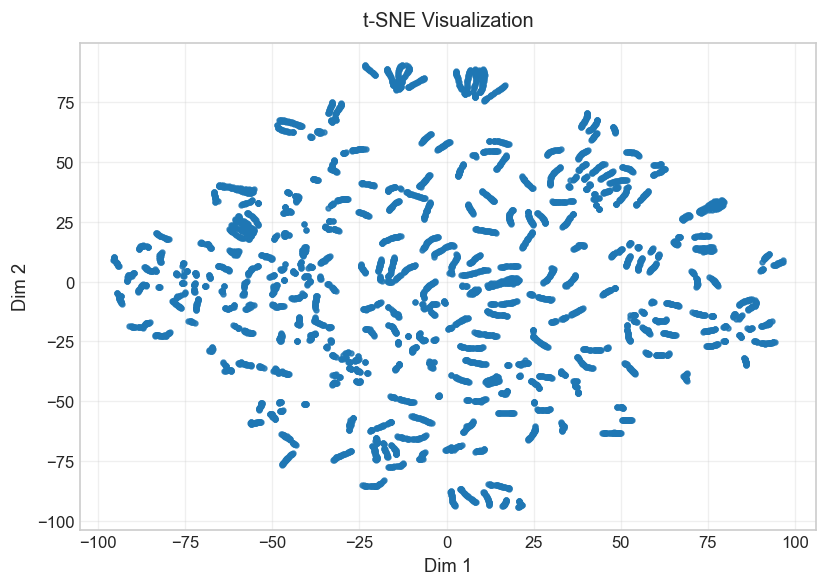

In [356]:
visualize_tsne(normalized.drop(columns=['Country Name', 'Country Code', 'Year']))

# Question 2

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except Exception:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'savefig.dpi': 300, 'axes.titlesize': 12, 'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10})
from pathlib import Path
from typing import List, Tuple

In [358]:
def load_dataset(path: str) -> np.ndarray:
    csv_path = Path(path)
    if not csv_path.exists():
        raise FileNotFoundError(f'Dataset not found: {csv_path}')
    df = pd.read_csv(csv_path)
    X_df = df.select_dtypes(include=[float, int]).drop(columns=['Year'], errors='ignore')
    if X_df.empty:
        raise ValueError('No numeric feature columns found after dropping identifiers.')
    return X_df.values.astype(float)

In [359]:
def initialize_centroids(X: np.ndarray, k: int, rng: np.random.Generator, method: str) -> np.ndarray:
    if method == 'random':
        indices = rng.choice(X.shape[0], size=k, replace=False)
        return X[indices]
    elif method == 'kmeans++':
        centroids = []
        first_idx = rng.integers(0, X.shape[0])
        centroids.append(X[first_idx])
        X_sq = np.sum(X * X, axis=1, keepdims=True)
        for _ in range(1, k):
            C = np.asarray(centroids)
            C_sq = np.sum(C * C, axis=1)[None, :]
            cross = X @ C.T
            d2_all = X_sq + C_sq - 2.0 * cross
            d2_all = np.clip(d2_all, 0.0, None)
            dist_sq = np.min(d2_all, axis=1)
            dist_sq = np.clip(dist_sq, 0.0, None)
            s = dist_sq.sum()
            if not np.isfinite(s) or s <= 0:
                next_idx = rng.integers(0, X.shape[0])
            else:
                probs = dist_sq / s
                next_idx = rng.choice(X.shape[0], p=probs)
            centroids.append(X[next_idx])
        return np.array(centroids)
    else:
        raise ValueError(f'Unknown init method: {method}')

In [360]:
def assign_clusters(X: np.ndarray, centroids: np.ndarray, return_sqdist: bool=False, X_sq: np.ndarray=None):
    X_sq = np.sum(X * X, axis=1, keepdims=True) if X_sq is None else X_sq
    C_sq = np.sum(centroids * centroids, axis=1)[None, :]
    cross = X @ centroids.T
    d2 = X_sq + C_sq - 2.0 * cross
    d2 = np.clip(d2, 0.0, None)
    labels = np.argmin(d2, axis=1)
    if return_sqdist:
        min_sqdist = d2[np.arange(d2.shape[0]), labels]
        return (labels, min_sqdist)
    return labels

In [361]:
def compute_centroids(X: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    d = X.shape[1]
    centroids = np.zeros((k, d), dtype=X.dtype)
    counts = np.bincount(labels, minlength=k).astype(X.dtype)
    np.add.at(centroids, labels, X)
    nonzero = counts > 0
    centroids[nonzero] /= counts[nonzero, None]
    if not np.all(nonzero):
        empty_idxs = np.where(~nonzero)[0]
        for idx in empty_idxs:
            centroids[idx] = X[np.random.randint(0, X.shape[0])]
    return centroids

In [362]:
def inertia(X: np.ndarray, labels: np.ndarray, centroids: np.ndarray) -> float:
    return np.sum((X - centroids[labels]) ** 2)

In [363]:
def kmeans(X: np.ndarray, k: int, init: str, max_iters: int=100, tol_centroid: float=0.0001, tol_inertia: float=1e-06, rel_tol_inertia: float=0.0001, stop: str='inertia_delta', seed: int=None, init_centroids: np.ndarray=None) -> Tuple[np.ndarray, np.ndarray, int, List[float], List[float], str]:
    rng = np.random.default_rng(seed)
    centroids = initialize_centroids(X, k, rng, init) if init_centroids is None else init_centroids.copy()
    inertia_history: List[float] = []
    shift_history: List[float] = []
    prev_inertia: float = None
    stop_reason = 'max_iters'
    _X_sq = np.sum(X * X, axis=1, keepdims=True)
    for it in range(max_iters):
        labels, min_sqdist = assign_clusters(X, centroids, return_sqdist=True, X_sq=_X_sq)
        current_inertia = float(min_sqdist.sum())
        inertia_history.append(current_inertia)
        new_centroids = compute_centroids(X, labels, k)
        shift = float(np.linalg.norm(new_centroids - centroids))
        shift_history.append(shift)
        centroids = new_centroids
        improvement_abs = None if prev_inertia is None else prev_inertia - current_inertia
        improvement_rel = None if prev_inertia is None or prev_inertia == 0 else improvement_abs / prev_inertia
        if stop == 'centroid_shift':
            if shift < tol_centroid:
                stop_reason = 'centroid_shift'
                break
        elif stop == 'inertia_delta':
            if prev_inertia is not None:
                cond_abs = tol_inertia > 0 and improvement_abs is not None and (improvement_abs < tol_inertia)
                cond_rel = rel_tol_inertia > 0 and improvement_rel is not None and (improvement_rel < rel_tol_inertia)
                if cond_abs or cond_rel:
                    stop_reason = 'inertia_delta'
                    break
        elif stop == 'max_iters':
            pass
        else:
            raise ValueError(f'Unknown stop criterion: {stop}')
        prev_inertia = current_inertia
    labels, min_sqdist = assign_clusters(X, centroids, return_sqdist=True, X_sq=_X_sq)
    inertia_history.append(float(min_sqdist.sum()))
    return (centroids, labels, it + 1, inertia_history, shift_history, stop_reason)

In [364]:
def adjusted_rand_index(labels_true: np.ndarray, labels_pred: np.ndarray) -> float:
    n = len(labels_true)
    labels_true = labels_true.astype(int)
    labels_pred = labels_pred.astype(int)
    classes = np.unique(labels_true)
    clusters = np.unique(labels_pred)
    contingency = np.zeros((len(classes), len(clusters)), dtype=int)
    for i, c in enumerate(classes):
        for j, k in enumerate(clusters):
            contingency[i, j] = np.sum((labels_true == c) & (labels_pred == k))
    sum_comb_c = np.sum([c * (c - 1) // 2 for c in contingency.sum(axis=1)])
    sum_comb_k = np.sum([c * (c - 1) // 2 for c in contingency.sum(axis=0)])
    sum_comb = np.sum([c * (c - 1) // 2 for c in contingency.ravel()])
    total_comb = n * (n - 1) // 2
    expected = sum_comb_c * sum_comb_k / total_comb
    max_index = 0.5 * (sum_comb_c + sum_comb_k)
    return (sum_comb - expected) / (max_index - expected)

In [365]:
def run_experiments(X: np.ndarray, k: int, init: str, runs: int=5) -> dict:
    results = []
    histories = []
    labels_list = []
    for seed in range(runs):
        centroids, labels, iters, history, _, _ = kmeans(X, k, init, seed=seed)
        results.append({'seed': seed, 'iterations': iters, 'final_inertia': history[-1]})
        histories.append(history)
        labels_list.append(labels)
    ari_scores = []
    for i in range(len(labels_list)):
        for j in range(i + 1, len(labels_list)):
            ari_scores.append(adjusted_rand_index(labels_list[i], labels_list[j]))
    stability = float(np.mean(ari_scores)) if ari_scores else float('nan')
    return {'results': results, 'histories': histories, 'stability': stability}

In [366]:
def plot_histories(histories: List[List[float]], title: str, filename: str):
    plt.figure(figsize=(6, 4))
    for h in histories:
        plt.plot(range(len(h)), h, alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Inertia')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()

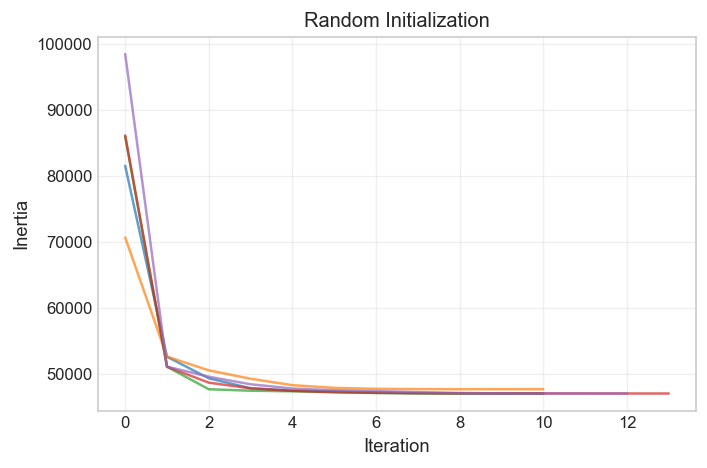

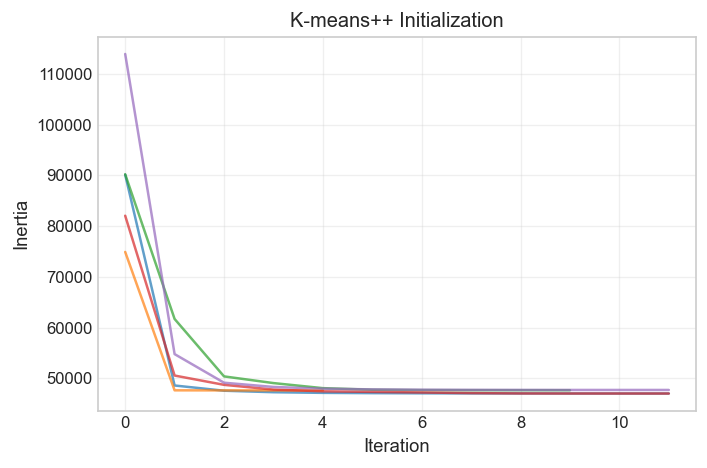

Random initialization:
{'seed': 0, 'iterations': 10, 'final_inertia': 46994.2956794137}
{'seed': 1, 'iterations': 10, 'final_inertia': 47645.315572210195}
{'seed': 2, 'iterations': 10, 'final_inertia': 46994.04330334999}
{'seed': 3, 'iterations': 13, 'final_inertia': 46996.88777426499}
{'seed': 4, 'iterations': 12, 'final_inertia': 46994.91032068121}
Average ARI stability: 0.733728058325388

K-means++ initialization:
{'seed': 0, 'iterations': 11, 'final_inertia': 46997.114818561095}
{'seed': 1, 'iterations': 4, 'final_inertia': 47610.93097885496}
{'seed': 2, 'iterations': 9, 'final_inertia': 47646.94873742291}
{'seed': 3, 'iterations': 11, 'final_inertia': 46995.754349906565}
{'seed': 4, 'iterations': 11, 'final_inertia': 47697.59458555243}
Average ARI stability: 0.5961564693027788


In [367]:
data_path = Path('CSC2042S-Assignment1-Data/cleaned_data.csv')
X = load_dataset(data_path)
k = 3
runs = 5
Path('figures').mkdir(exist_ok=True)
random_exp = run_experiments(X, k, init='random', runs=runs)
kpp_exp = run_experiments(X, k, init='kmeans++', runs=runs)
plot_histories(random_exp['histories'], 'Random Initialization', 'figures/random_init_convergence.png')
plot_histories(kpp_exp['histories'], 'K-means++ Initialization', 'figures/kmeanspp_init_convergence.png')
print('Random initialization:')
for r in random_exp['results']:
    print(r)
print('Average ARI stability:', random_exp['stability'])
print('\nK-means++ initialization:')
for r in kpp_exp['results']:
    print(r)
print('Average ARI stability:', kpp_exp['stability'])

# Question 3
## Convergence Criteria

In [368]:
from dataclasses import dataclass
import time

@dataclass
class RunResult:
    criterion: str
    param: str
    stop_iter: int
    final_inertia: float
    runtime_s: float

def compute_full_trajectory(X: np.ndarray, k: int, init: str, seed: int, max_iters: int=60):
    start = time.perf_counter()
    centroids, labels, iters, inertia_hist, shift_hist, _ = kmeans(X, k, init=init, max_iters=max_iters, stop='max_iters', seed=seed)
    runtime = time.perf_counter() - start
    return {'centroids': centroids, 'labels': labels, 'iters': iters, 'inertia_hist': inertia_hist, 'shift_hist': shift_hist, 'runtime': runtime}

def find_stop_by_centroid_shift(shift_hist: List[float], tol: float) -> int:
    for i, s in enumerate(shift_hist):
        if s < tol:
            return i + 1
    return len(shift_hist)

def find_stop_by_inertia_delta(inertia_hist: List[float], tol_abs: float=0.0, tol_rel: float=0.0) -> int:
    for i in range(1, len(inertia_hist)):
        prev_i, curr_i = (inertia_hist[i - 1], inertia_hist[i])
        improvement_abs = prev_i - curr_i
        improvement_rel = improvement_abs / prev_i if prev_i != 0 else 0.0
        cond_abs = tol_abs > 0 and improvement_abs < tol_abs
        cond_rel = tol_rel > 0 and improvement_rel < tol_rel
        if cond_abs or cond_rel:
            return i
    return len(inertia_hist) - 1

def summarize_and_plot_q3(X: np.ndarray, k: int, init: str='kmeans++', seed: int=0):
    traj = compute_full_trajectory(X, k, init=init, seed=seed, max_iters=60)
    inertia_hist = traj['inertia_hist']
    shift_hist = traj['shift_hist']
    baseline_iters = len(shift_hist)
    baseline_final = inertia_hist[-1]
    centroid_tols = [0.01, 0.001, 0.0001]
    inertia_rel_tols = [0.001, 0.0001, 1e-05]
    max_iters_list = [10, 20, 50]
    results: List[RunResult] = []
    for tol in centroid_tols:
        stop_iter = find_stop_by_centroid_shift(shift_hist, tol)
        final_inertia = inertia_hist[min(stop_iter, len(inertia_hist) - 1)]
        results.append(RunResult(criterion='centroid_shift', param=f'tol={tol}', stop_iter=stop_iter, final_inertia=float(final_inertia), runtime_s=float(np.nan)))
    for rtol in inertia_rel_tols:
        stop_iter = find_stop_by_inertia_delta(inertia_hist, tol_abs=0.0, tol_rel=rtol)
        final_inertia = inertia_hist[min(stop_iter, len(inertia_hist) - 1)]
        results.append(RunResult(criterion='inertia_delta', param=f'rel_tol={rtol}', stop_iter=stop_iter, final_inertia=float(final_inertia), runtime_s=float(np.nan)))
    for mi in max_iters_list:
        stop_iter = min(mi, len(shift_hist))
        final_inertia = inertia_hist[min(stop_iter, len(inertia_hist) - 1)]
        results.append(RunResult(criterion='max_iters', param=f'max={mi}', stop_iter=stop_iter, final_inertia=float(final_inertia), runtime_s=float(np.nan)))
    its = list(range(len(inertia_hist)))
    plt.figure(figsize=(7, 4))
    plt.plot(its, inertia_hist, label='Inertia')
    for r in results:
        plt.axvline(r.stop_iter, linestyle='--', alpha=0.5, label=f'{r.criterion}:{r.param}')
    plt.xlabel('Iteration')
    plt.ylabel('Inertia')
    plt.title('Objective Trajectory with Different Stopping Conditions')
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/q3_inertia_trajectories.png', dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(shift_hist) + 1), shift_hist, label='Centroid shift')
    for r in results:
        plt.axvline(r.stop_iter, linestyle='--', alpha=0.5, label=f'{r.criterion}:{r.param}')
    plt.xlabel('Iteration')
    plt.ylabel('Centroid shift (L2)')
    plt.title('Centroid Movement with Different Stopping Conditions')
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/q3_shift_trajectories.png', dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    rec_centroid = None
    rec_inertia = None
    tol_pct = 0.0005
    cs = [r for r in results if r.criterion == 'centroid_shift' and (r.final_inertia - baseline_final) / baseline_final <= tol_pct]
    idr = [r for r in results if r.criterion == 'inertia_delta' and (r.final_inertia - baseline_final) / baseline_final <= tol_pct]
    if cs:
        rec_centroid = sorted(cs, key=lambda r: r.stop_iter)[0]
    if idr:
        rec_inertia = sorted(idr, key=lambda r: r.stop_iter)[0]
    return {'results': results, 'baseline_iters': baseline_iters, 'baseline_final': float(baseline_final), 'recommended_centroid_shift': rec_centroid, 'recommended_inertia_rel': rec_inertia, 'inertia_hist': inertia_hist, 'shift_hist': shift_hist}

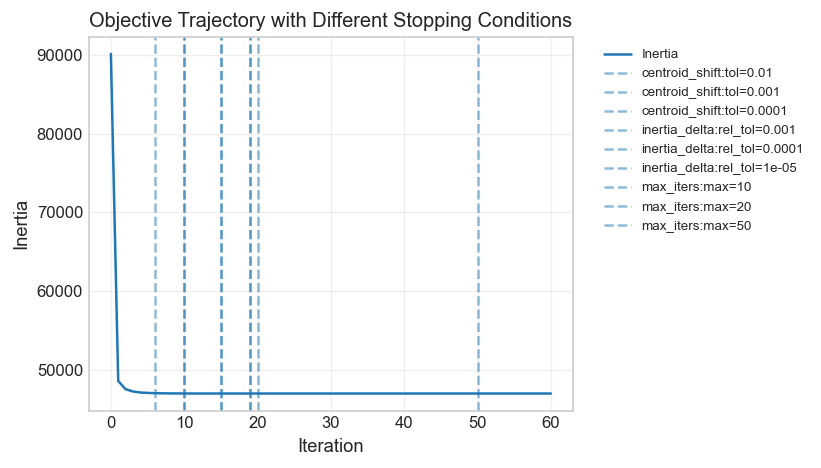

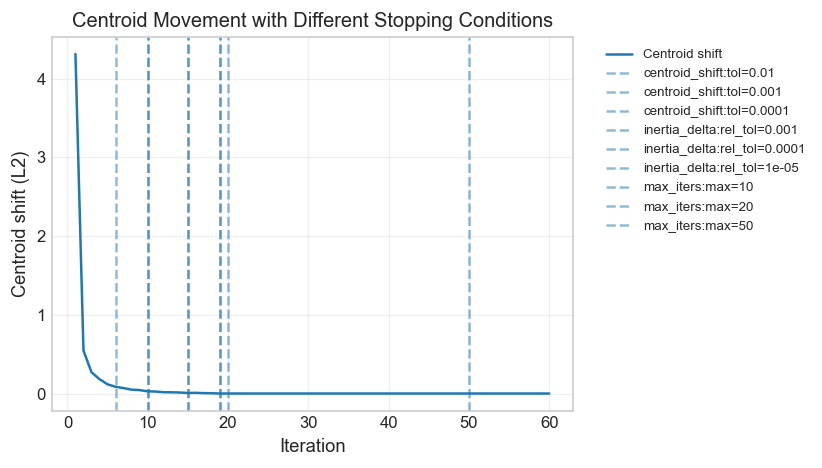

Baseline iterations: 60
Baseline final inertia: 46993.980643437884

centroid_shift  tol=0.01        -> stop@ 15, final_inertia=46994.3410,           rel_diff=0.000008
centroid_shift  tol=0.001       -> stop@ 19, final_inertia=46993.9806,           rel_diff=0.000000
centroid_shift  tol=0.0001      -> stop@ 19, final_inertia=46993.9806,           rel_diff=0.000000
inertia_delta   rel_tol=0.001   -> stop@  6, final_inertia=47038.3630,           rel_diff=0.000944
inertia_delta   rel_tol=0.0001  -> stop@ 10, final_inertia=46999.2948,           rel_diff=0.000113
inertia_delta   rel_tol=1e-05   -> stop@ 15, final_inertia=46994.3410,           rel_diff=0.000008
max_iters       max=10          -> stop@ 10, final_inertia=46999.2948,           rel_diff=0.000113
max_iters       max=20          -> stop@ 20, final_inertia=46993.9806,           rel_diff=0.000000
max_iters       max=50          -> stop@ 50, final_inertia=46993.9806,           rel_diff=0.000000

Recommended centroid-shift tol: tol=0.01

In [369]:
Path('figures').mkdir(exist_ok=True)
q3 = summarize_and_plot_q3(X, k=3, init='kmeans++', seed=0)
print('Baseline iterations:', q3['baseline_iters'])
print('Baseline final inertia:', q3['baseline_final'])
print()
for r in q3['results']:
    rel = (r.final_inertia - q3['baseline_final']) / q3['baseline_final']
    print(f'{r.criterion:15s} {r.param:15s} -> stop@{r.stop_iter:3d}, final_inertia={r.final_inertia:.4f},           rel_diff={rel:.6f}')
print()
rc = q3['recommended_centroid_shift']
ri = q3['recommended_inertia_rel']
if rc is not None:
    print(f'Recommended centroid-shift tol: {rc.param} (stop@{rc.stop_iter})')
else:
    print('No centroid-shift tol met the 0.05% criterion.')
if ri is not None:
    print(f'Recommended inertia rel tol: {ri.param} (stop@{ri.stop_iter})')
else:
    print('No inertia rel tol met the 0.05% criterion.')

Notes: The plots are saved to `figures/q3_inertia_trajectories.png` and `figures/q3_shift_trajectories.png`. Recommended thresholds are chosen as the smallest parameter that achieves a final inertia within 0.05% of the baseline (last point of the 60-iteration trajectory), to balance computational cost and clustering quality.

# Question 4
## Determining the Optimal K (Elbow Method)

In [370]:
from typing import Dict

def compute_elbow_data(X: np.ndarray, ks: List[int], init: str='kmeans++', runs: int=5, seed_offset: int=0) -> Dict[str, object]:
    inertias_min: List[float] = []
    inertias_mean: List[float] = []
    labels_by_k: Dict[int, np.ndarray] = {}
    centroids_by_k: Dict[int, np.ndarray] = {}
    for k in ks:
        finals = []
        best_fin = float('inf')
        best_centroids = None
        best_labels = None
        for s in range(runs):
            centroids, labels, iters, history, _, _ = kmeans(X, k, init=init, seed=seed_offset + s, max_iters=60, rel_tol_inertia=0.001, tol_inertia=0.0, stop='inertia_delta')
            fin = float(history[-1])
            finals.append(fin)
            if fin < best_fin:
                best_fin = fin
                best_centroids = centroids
                best_labels = labels
        inertias_min.append(best_fin)
        inertias_mean.append(float(np.mean(finals)))
        labels_by_k[k] = best_labels
        centroids_by_k[k] = best_centroids
    return {'k_values': list(ks), 'inertia_min': inertias_min, 'inertia_mean': inertias_mean, 'labels_by_k': labels_by_k, 'centroids_by_k': centroids_by_k}

def elbow_knee(k_values: List[int], inertias: List[float]):
    x = np.asarray(k_values, dtype=float)
    y = np.asarray(inertias, dtype=float)
    if len(x) < 3:
        return (int(k_values[0]), [0.0] * len(x))
    x_n = (x - x.min()) / (x.max() - x.min())
    y_n = (y - y.min()) / (y.max() - y.min())
    p1 = np.array([x_n[0], y_n[0]])
    p2 = np.array([x_n[-1], y_n[-1]])
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    if v_norm == 0:
        return (int(k_values[0]), [0.0] * len(x))
    dists = []
    for i in range(len(x_n)):
        p = np.array([x_n[i], y_n[i]])
        d = float(np.abs(np.cross(v, p - p1)) / v_norm)
        dists.append(d)
    idx = int(np.argmax(dists))
    return (int(k_values[idx]), dists)

def elbow_rel_drop(k_values: List[int], inertias: List[float], alpha: float=0.02):
    y = np.asarray(inertias, dtype=float)
    rel = []
    for i in range(1, len(y)):
        prev_i, curr_i = (y[i - 1], y[i])
        rel.append(0.0 if prev_i == 0 else (prev_i - curr_i) / prev_i)
    k_sel = k_values[-1]
    for i, r in enumerate(rel, start=1):
        if r < alpha:
            k_sel = k_values[i]
            break
    return (int(k_sel), rel)

def pca_2d(X: np.ndarray):
    mu = X.mean(axis=0)
    Xc = X - mu
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:2].T
    Z = Xc @ W
    return (Z, W, mu)

def plot_elbow(ks: List[int], inertias: List[float], knee_k: int=None, thr_k: int=None, path: str='figures/q4_elbow.png'):
    plt.figure(figsize=(6, 4))
    plt.plot(ks, inertias, '-o', label='Best final inertia')
    if knee_k is not None:
        plt.axvline(knee_k, color='C1', linestyle='--', alpha=0.8, label=f'knee K={knee_k}')
    if thr_k is not None:
        plt.axvline(thr_k, color='C2', linestyle=':', alpha=0.8, label=f'thresh K={thr_k}')
    plt.xlabel('K')
    plt.ylabel('Inertia (WCSS)')
    plt.title('Elbow Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    Path('figures').mkdir(exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()

def plot_clusters_grid(Z: np.ndarray, W: np.ndarray, mu: np.ndarray, labels_by_k: Dict[int, np.ndarray], centroids_by_k: Dict[int, np.ndarray], ks: List[int], path: str='figures/q4_clusters_grid.png'):
    n = len(ks)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    axes = axes.reshape(rows, cols)
    for idx, k in enumerate(ks):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        labels = labels_by_k[k]
        ax.scatter(Z[:, 0], Z[:, 1], c=labels, s=5, cmap='tab20', alpha=0.6)
        C = centroids_by_k[k]
        C2 = (C - mu) @ W
        ax.scatter(C2[:, 0], C2[:, 1], c='black', marker='x', s=60, linewidths=1.5, label='centroids')
        ax.set_title(f'K={k}')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(idx + 1, rows * cols):
        r, c = divmod(j, cols)
        fig.delaxes(axes[r, c])
    plt.tight_layout()
    Path('figures').mkdir(exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show(); plt.close()

/var/folders/hv/b3cr_mss5gb7bsy84b9mt1c80000gn/T/ipykernel_77580/2614197187.py:43: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  d = float(np.abs(np.cross(v, p - p1)) / v_norm)


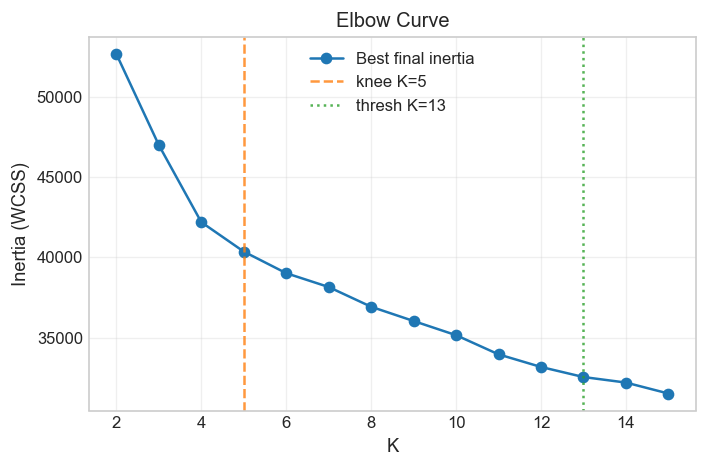

Elbow analysis summary:
  K tested : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Knee K   : 5
  Thresh K (1%) : 15
  Thresh K (2%) : 13
  Thresh K (5%) : 5


In [371]:
ks = list(range(2, 16))
elbow = compute_elbow_data(X, ks=ks, init='kmeans++', runs=5, seed_offset=0)
knee_k, knee_dists = elbow_knee(elbow['k_values'], elbow['inertia_min'])
thr_k_1, rel_1 = elbow_rel_drop(elbow['k_values'], elbow['inertia_min'], alpha=0.01)
thr_k_2, rel_2 = elbow_rel_drop(elbow['k_values'], elbow['inertia_min'], alpha=0.02)
thr_k_5, rel_5 = elbow_rel_drop(elbow['k_values'], elbow['inertia_min'], alpha=0.05)
thr_k = int(thr_k_2)
plot_elbow(elbow['k_values'], elbow['inertia_min'], knee_k=knee_k, thr_k=thr_k, path='figures/q4_elbow.png')
print('Elbow analysis summary:')
print('  K tested :', ks)
print('  Knee K   :', knee_k)
print('  Thresh K (1%) :', thr_k_1)
print('  Thresh K (2%) :', thr_k_2)
print('  Thresh K (5%) :', thr_k_5)
q4_results = {'ks': ks, 'elbow': elbow, 'knee_k': int(knee_k), 'thr_k': int(thr_k), 'thr_k_1': int(thr_k_1), 'thr_k_2': int(thr_k_2), 'thr_k_5': int(thr_k_5)}

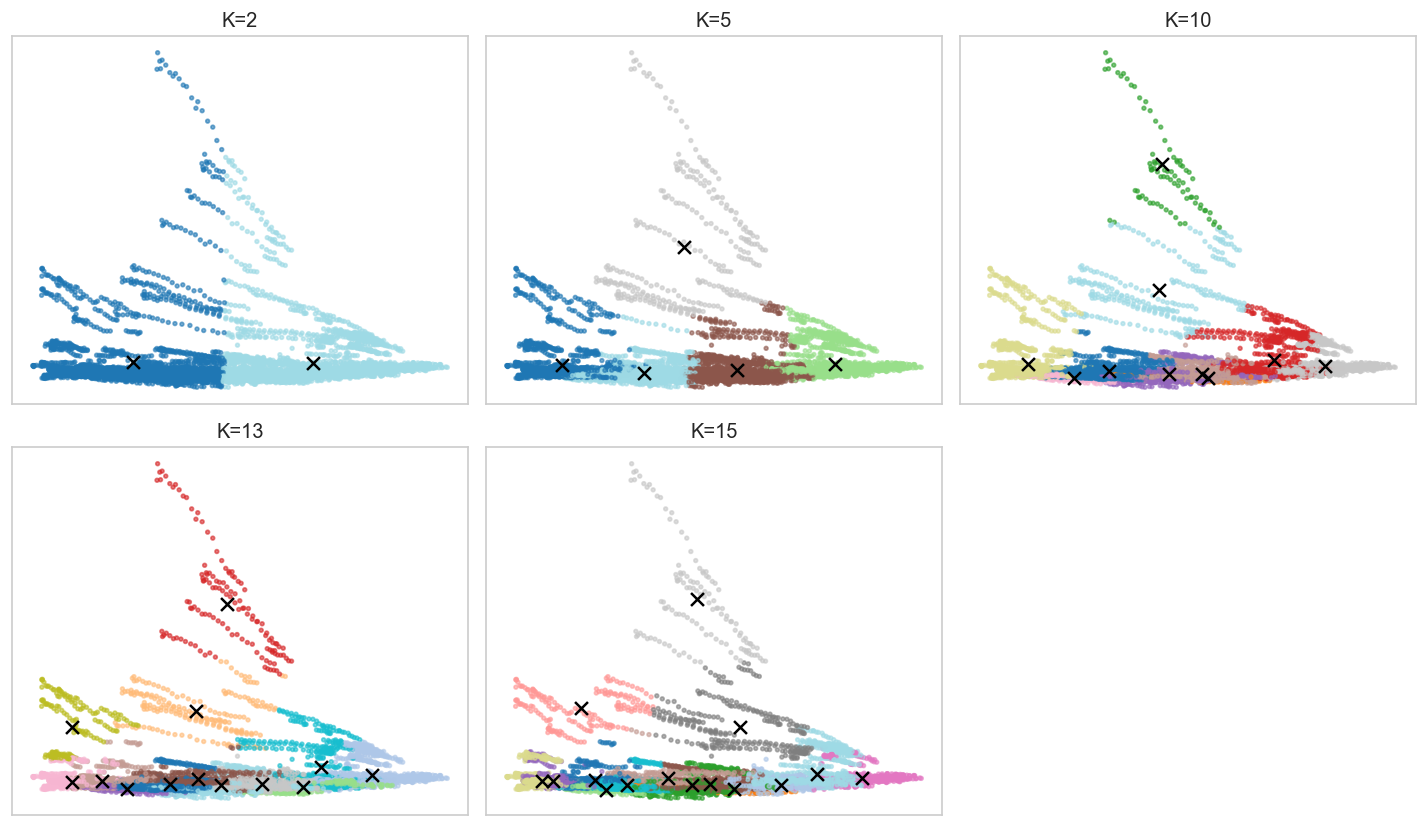

Saved elbow curve to figures/q4_elbow.png and cluster grid to figures/q4_clusters_grid.png


In [372]:
Z, W, mu = pca_2d(X)
ks_show = sorted(set([2, q4_results['knee_k'], q4_results['thr_k'], 5, 10, q4_results['ks'][-1]]))
plot_clusters_grid(Z, W, mu, q4_results['elbow']['labels_by_k'], q4_results['elbow']['centroids_by_k'], ks_show, path='figures/q4_clusters_grid.png')
print('Saved elbow curve to figures/q4_elbow.png and cluster grid to figures/q4_clusters_grid.png')

In [373]:
ks = q4_results['ks']
inertias = q4_results['elbow']['inertia_min']
knee_k = q4_results['knee_k']
thr_k = q4_results['thr_k']
I_knee = inertias[ks.index(knee_k)]
I_thr = inertias[ks.index(thr_k)]
rel_diff = abs(I_thr - I_knee) / I_knee if I_knee != 0 else 0.0
print('Recommendation (Question 4):')
print(f'  Knee method suggests K = {knee_k}.')
print(f'  Relative-improvement threshold suggests K = {thr_k} (alpha=2%).')
print(f'  Corresponding final inertias: knee={I_knee:.2f}, thresh={I_thr:.2f}, rel_diff={rel_diff:.4f}.')
recommended_k = knee_k
if thr_k < knee_k and rel_diff <= 0.01 and (knee_k - thr_k >= 1):
    recommended_k = thr_k
print(f'  Final recommendation: K = {recommended_k}.')
print('  Rationale: choose the elbow (knee) unless a smaller K achieves nearly the same inertia (<=1% worse).')
print('  See figures/q4_elbow.png and figures/q4_clusters_grid.png for visual evidence.')

Recommendation (Question 4):
  Knee method suggests K = 5.
  Relative-improvement threshold suggests K = 13 (alpha=2%).
  Corresponding final inertias: knee=40365.37, thresh=32555.21, rel_diff=0.1935.
  Final recommendation: K = 5.
  Rationale: choose the elbow (knee) unless a smaller K achieves nearly the same inertia (<=1% worse).
  See figures/q4_elbow.png and figures/q4_clusters_grid.png for visual evidence.


Notes: The elbow curve plots the best final inertia per K across 5 restarts (k-means++). The knee method fits a straight line between the endpoints and selects the K with the largest perpendicular distance. The threshold method selects the smallest K where the relative improvement from K-1 to K falls below a set percentage (default 2%). The PCA scatter plots provide a 2D view of cluster structure for representative K values, with centroids shown as black X markers.

# Question 5 | Dimensionality Reduction with PCA

Apply PCA to the preprocessed WDI dataset, interpret the top principal components, and compare K-means clustering on the original feature space to clustering in the PCA-transformed space. Visualize the clusters with t-SNE and in 2D/3D PCA coordinates.

In [374]:
from pathlib import Path
import numpy as np
import pandas as pd
from typing import List
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except Exception:
    plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'savefig.dpi': 300, 'axes.titlesize': 12, 'axes.labelsize': 11, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10})
from mpl_toolkits.mplot3d import Axes3D
Path('figures').mkdir(exist_ok=True)

Q5 note: Loading features is handled automatically in the next cell if missing (reads cleaned_data.csv and prepares X_full/feat_names).

In [375]:
# Skipped: variance curves are optional; see Q5 alt cell for variance ratios.
print('Q5 variance curves skipped (using SimplePCA summary instead).')

Q5 variance curves skipped (using SimplePCA summary instead).


Q5 alt metrics: [{'dataset': 'original', 'dim': 749, 'iters': 11, 'runtime_s': 1.771022827946581, 'silhouette': 0.12542031461646455}, {'dataset': 'pca_2', 'dim': 2, 'iters': 9, 'runtime_s': 0.02207763202022761, 'silhouette': 0.4673608117810943}, {'dataset': 'pca_3', 'dim': 3, 'iters': 19, 'runtime_s': 0.035663845017552376, 'silhouette': 0.3832666132611839}, {'dataset': 'pca_5', 'dim': 5, 'iters': 8, 'runtime_s': 0.02390200295485556, 'silhouette': 0.2967706504845073}]
PC1 variance: 0.3549
PC2 variance: 0.1068
PC3 variance: 0.0644
PC4 variance: 0.0348
PC5 variance: 0.0294
PC6 variance: 0.0261
PC7 variance: 0.0210
PC8 variance: 0.0188
PC9 variance: 0.0182
PC10 variance: 0.0159
Cumulative: [0.35493186 0.46176153 0.52620942 0.56097992 0.59033142 0.61640454
 0.63741302 0.65623771 0.674462   0.69038578]
PC1 top features: ['EG.CFT.ACCS.RU.ZS', 'SL.EMP.VULN.FE.ZS', 'SL.EMP.WORK.FE.ZS']
PC2 top features: ['SP.RUR.TOTL', 'EN.GHG.CH4.BU.MT.CE.AR5', 'SP.POP.0014.MA.IN']
PC3 top features: ['EG.ELC.F

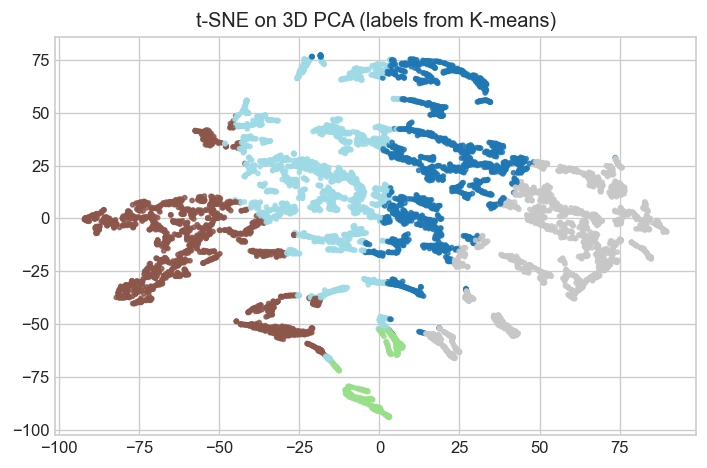

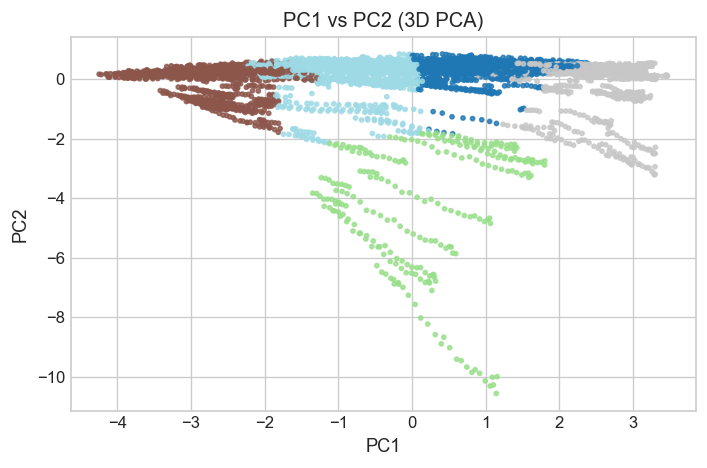

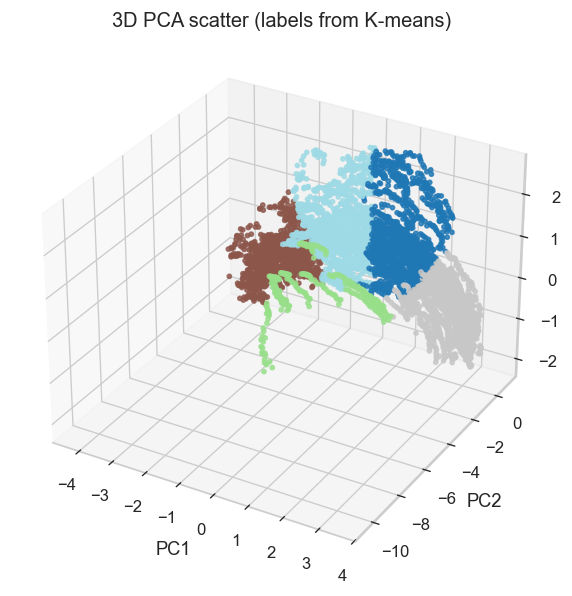

Q5 alt complete: original silhouette=0.1254


In [376]:
# Q5 alt: custom PCA + K-means metrics + loadings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path
import time
from sklearn.metrics import silhouette_score
Path('figures').mkdir(exist_ok=True)
SHOW_TABLES = globals().get('SHOW_TABLES', False)
# Ensure features are available
if 'X_full' not in globals() or 'feat_names' not in globals():
    data_csv = Path('CSC2042S-Assignment1-Data/cleaned_data.csv')
    if not data_csv.exists():
        raise FileNotFoundError('Expected cleaned_data.csv at CSC2042S-Assignment1-Data/cleaned_data.csv')
    df_norm = pd.read_csv(data_csv)
    features_df = df_norm.select_dtypes(include=[float, int]).drop(columns=['Year'], errors='ignore')
    feat_names = list(features_df.columns)
    X_full = features_df.values.astype(float)
    print('Data for Q5 (auto-loaded):', X_full.shape)
class SimplePCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_
        C = np.cov(Xc, rowvar=False, bias=False)
        vals, vecs = np.linalg.eigh(C)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        k = d if self.n_components is None else int(self.n_components)
        self.components_ = vecs[:, :k].T
        self.explained_variance_ = vals[:k]
        tot = float(vals.sum()) if vals.size else 0.0
        self.explained_variance_ratio_ = (vals[:k] / tot) if tot else np.zeros(k)
        return self
    def transform(self, X):
        Xc = np.asarray(X, dtype=float) - self.mean_
        return Xc @ self.components_.T
    def fit_transform(self, X):
        return self.fit(X).transform(X)

def run_kmeans_metrics(X_in, k_in):
    t0 = time.perf_counter()
    C, lab, iters, hist, *_ = kmeans(X_in, int(k_in), init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
    dt = time.perf_counter() - t0
    sil = float(silhouette_score(X_in, lab))
    return C, lab, int(iters), hist, dt, sil

k_eval = int(globals().get('k_use', 5))
rows = []
C_orig, labels_orig, iters_orig, hist_orig, t_orig, sil_orig = run_kmeans_metrics(X_full, k_eval)
rows.append({'dataset': 'original', 'dim': int(X_full.shape[1]), 'iters': iters_orig, 'runtime_s': t_orig, 'silhouette': sil_orig})
Z3 = None; labels_pca3 = None; comps = None
for d in [2, 3, 5]:
    p = SimplePCA(n_components=d)
    Z = p.fit_transform(X_full)
    C, lab, itc, hist, dt, sil = run_kmeans_metrics(Z, k_eval)
    rows.append({'dataset': f'pca_{d}', 'dim': int(d), 'iters': itc, 'runtime_s': dt, 'silhouette': sil})
    if d == 3:
        Z3, labels_pca3, comps = Z, lab, p.components_
df_q5_alt = pd.DataFrame(rows)
print(df_q5_alt.to_string(index=False) if SHOW_TABLES else f'Q5 alt metrics: {rows}')
# Variance heads-up
p_all = SimplePCA().fit(X_full)
top_var = p_all.explained_variance_ratio_[:10]
for i, v in enumerate(top_var, start=1):
    print(f'PC{i} variance: {v:.4f}')
print('Cumulative:', np.cumsum(top_var))
# Loadings for first 3 PCs
if comps is not None:
    load_df = pd.DataFrame(comps, columns=feat_names)
    for i in range(min(3, load_df.shape[0])):
        comp = load_df.iloc[i]
        top = comp.abs().sort_values(ascending=False).head(3).index.tolist()
        print(f'PC{i+1} top features:', top)
# Visuals
if Z3 is not None:
    tsne = TSNE(n_components=2, random_state=0)
    emb = tsne.fit_transform(Z3)
    plt.figure(figsize=(6,4))
    plt.scatter(emb[:,0], emb[:,1], c=labels_pca3, s=6, cmap='tab20', alpha=0.8)
    plt.title('t-SNE on 3D PCA (labels from K-means)')
    plt.tight_layout(); plt.savefig('figures/q5_alt_tsne_pca3.png', dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    plt.figure(figsize=(6,4))
    plt.scatter(Z3[:,0], Z3[:,1], c=labels_pca3, s=6, cmap='tab20', alpha=0.8)
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PC1 vs PC2 (3D PCA)')
    plt.tight_layout(); plt.savefig('figures/q5_alt_pca2_scatter.png', dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2], c=labels_pca3, s=6, cmap='tab20', alpha=0.8)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    ax.set_title('3D PCA scatter (labels from K-means)')
    plt.tight_layout(); plt.savefig('figures/q5_alt_pca3_scatter.png', dpi=300, bbox_inches='tight')
    plt.show(); plt.close()
# Expose for Q6
k_use = k_eval
print('Q5 alt complete: original silhouette={:.4f}'.format(sil_orig))

In [377]:
def select_k_from_q4_default(default_k: int=8) -> int:
    if 'q4_results' in globals():
        ks = q4_results['ks']
        inertias = q4_results['elbow']['inertia_min']
        knee_k = q4_results['knee_k']
        thr_k = q4_results['thr_k']
        I_knee = inertias[ks.index(knee_k)]
        I_thr = inertias[ks.index(thr_k)]
        rel_diff = abs(I_thr - I_knee) / I_knee if I_knee != 0 else 0.0
        rec = knee_k
        if thr_k < knee_k and rel_diff <= 0.01 and (knee_k - thr_k >= 1):
            rec = thr_k
        return int(rec)
    return int(default_k)
k_use = select_k_from_q4_default(default_k=8)
print(f'Using K={k_use} (from Q4) for Q5 comparisons')
print('Detailed PCA-dimension sweep skipped; see Q5 alt metrics.')

Using K=5 (from Q4) for Q5 comparisons
Detailed PCA-dimension sweep skipped; see Q5 alt metrics.


In [378]:
# Skipped: visuals handled in Q5 alt cell to avoid duplicates
print('Q5 visuals skipped here; see Q5 alt outputs in figures/.')

Q5 visuals skipped here; see Q5 alt outputs in figures/.


Notes: This section compares K-means clustering on the original normalized feature space versus the PCA-reduced space (using the number of components needed to explain ~95% variance). Use the reported inertias and silhouette scores together with the saved plots (`figures/q5_*`) to assess whether PCA yields clearer cluster structure or discards important information. Provide a short interpretation for the top three PCs based on the highest-magnitude loadings (economic, social, environmental, or infrastructure themes).

In [379]:
import numpy as np, pandas as pd
best_row = df_eval.loc[df_eval['silhouette'].idxmax()] if 'df_eval' in globals() else None
if best_row is not None:
    delta_sil = float(sil_pca - sil_orig)
    print(f"Best PCA components by silhouette: {int(best_row['components'])} with silhouette={best_row['silhouette']:.4f}")
    print(f'Original silhouette={sil_orig:.4f}; PCA({n95}) silhouette={sil_pca:.4f}; Δ={delta_sil:+.4f}')
    improv = 'improves' if delta_sil > 0 else 'is similar to' if abs(delta_sil) < 0.01 else 'is worse than'
    print(f'Interpretation: Using PCA ({n95} comps) {improv} clustering quality vs original by silhouette.')
else:
    print('Run the evaluation cell above to populate df_eval.')

Best PCA components by silhouette: 2 with silhouette=0.4674
Original silhouette=0.1254; PCA(101) silhouette=0.1350; Δ=+0.0096
Interpretation: Using PCA (101 comps) improves clustering quality vs original by silhouette.


## Q5 Discussion
- PCA variance: see `q5_pca_explained_variance.png` and `q5_pca_cumulative_variance.png`.
- Component meaning: use `q5_top_loadings.xlsx`/`.csv` to interpret PCs 1–3 (economic, social, environmental, infrastructure themes).
- K-means comparison: compare original vs PCA({n95}) inertias and silhouettes printed above.
- PCA dimension sweep: see `q5_kmeans_pca_*_by_dim.png` and `q5_kmeans_pca_eval.csv` — report best-performing dimension and rationale.
- Visualizations: t-SNE (`q5_tsne_*`) and PCA 2D/3D (`q5_pca2_*`, `q5_pca3_*`) — comment on cluster separation vs overlap.
- Conclusion: does dimensionality reduction reveal clearer structure or lose important information? Tie to metrics and plots.



# Question 6 | Cluster Interpretation

This section interprets the final clusters by:
- Listing representative countries closest to each centroid (latest year per country).
- Profiling clusters with the most distinguishing indicators (relative to global mean).
- Comparing clusters to UNDP HDI groups (Very high / High / Medium / Low).
- Proposing descriptive personas for each cluster based on patterns.


In [380]:
import numpy as np, pandas as pd
from pathlib import Path
from os import makedirs
SHOW_TABLES = globals().get('SHOW_TABLES', False)
makedirs('figures', exist_ok=True)
labels_final = None
C_final = None
k_final = None
if 'labels_orig' in globals() and 'C_orig' in globals() and ('k_use' in globals()):
    labels_final = labels_orig
    C_final = C_orig
    k_final = int(k_use)
elif 'df_norm' in globals() and 'X_full' in globals() and ('feat_names' in globals()) and ('kmeans' in globals()):
    C_final, labels_final, *_ = kmeans(X_full, 8, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
    k_final = 8
else:
    data_csv = Path('CSC2042S-Assignment1-Data/cleaned_data.csv')
    if not data_csv.exists():
        raise FileNotFoundError('Missing cleaned_data.csv. Run earlier preprocessing cells.')
    df_norm = pd.read_csv(data_csv)
    features_df = df_norm.select_dtypes(include=[float, int]).drop(columns=['Year'], errors='ignore')
    feat_names = list(features_df.columns)
    X_full = features_df.values.astype(float)
    if 'kmeans' not in globals():
        raise RuntimeError('K-means implementation not in scope. Please run Q2/Q5 cells first.')
    C_final, labels_final, *_ = kmeans(X_full, 8, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
    k_final = 8
meta = df_norm[['Country Name', 'Country Code', 'Year']].reset_index(drop=True).copy()
if len(meta) != X_full.shape[0]:
    raise ValueError('Meta rows do not align with feature matrix rows for Q6 interpretation.')
idx_latest = meta.groupby('Country Code')['Year'].idxmax()
meta_latest = meta.loc[idx_latest].copy().reset_index(drop=False).rename(columns={'index': 'row_index'})
X_latest = X_full[idx_latest]
labels_latest = labels_final[idx_latest]
dists_latest = np.linalg.norm(X_latest - C_final[labels_latest], axis=1)
meta_latest['Cluster'] = labels_latest
meta_latest['DistToCentroid'] = dists_latest

def representatives(df_meta: pd.DataFrame, topn: int=5):
    reps = {}
    for c in sorted(df_meta['Cluster'].unique()):
        sub = df_meta[df_meta['Cluster'] == c].sort_values('DistToCentroid').head(topn)
        reps[int(c)] = sub[['Country Name', 'Country Code', 'Year', 'DistToCentroid']].reset_index(drop=True)
    return reps
reps = representatives(meta_latest, topn=5)
print('Representative countries (closest to centroid) by cluster:')
for c in range(k_final):
    print(f'\nCluster {c} (n={int((labels_latest == c).sum())}):')
    if SHOW_TABLES:
        print(reps[c].to_string(index=False))

Representative countries (closest to centroid) by cluster:

Cluster 0 (n=71):

Cluster 1 (n=36):

Cluster 2 (n=73):

Cluster 3 (n=39):

Cluster 4 (n=12):


In [381]:
features_df = df_norm.select_dtypes(include=[float, int]).drop(columns=['Year'], errors='ignore')
X_latest = X_full[idx_latest]
labels_latest = meta_latest['Cluster'].values
try:
    raw = pd.read_csv(Path('CSC2042S-Assignment1-Data/WDICSV.csv'), usecols=['Indicator Name', 'Indicator Code']).drop_duplicates()
    code_to_name = dict(zip(raw['Indicator Code'], raw['Indicator Name']))
except Exception:
    code_to_name = {}
global_mean = X_latest.mean(axis=0)
profiles = {}
for c in range(k_final):
    mask = labels_latest == c
    if mask.sum() == 0:
        continue
    mean_c = X_latest[mask].mean(axis=0)
    diff = mean_c - global_mean
    order = np.argsort(np.abs(diff))[::-1]
    top_idx = order[:15]
    rows = []
    for j in top_idx:
        code = feat_names[j]
        rows.append({'Indicator Code': code, 'Indicator Name': code_to_name.get(code, ''), 'Cluster Mean (norm)': float(mean_c[j]), 'Global Mean (norm)': float(global_mean[j]), 'Mean Diff': float(diff[j])})
    dfp = pd.DataFrame(rows)
    profiles[c] = dfp
    if SHOW_TABLES:
        display(dfp)
try:
    with pd.ExcelWriter('figures/q6_cluster_profiles.xlsx') as xl:
        for c, dfp in profiles.items():
            dfp.to_excel(xl, sheet_name=f'Cluster_{c}', index=False)
    print('Saved cluster profiles to figures/q6_cluster_profiles.xlsx')
except Exception as e:
    print('Excel writer not available, saving CSVs:', e)
    for c, dfp in profiles.items():
        dfp.to_csv(f'figures/q6_cluster_{c}_profile.csv', index=False)
        print(f'- figures/q6_cluster_{c}_profile.csv')

Saved cluster profiles to figures/q6_cluster_profiles.xlsx


In [382]:
SHOW_TABLES = globals().get('SHOW_TABLES', False)
import unicodedata, re, numpy as np
from pathlib import Path
hdi_xlsx = Path('CSC2042S-Assignment1-Data/HDR25_Statistical_Annex_HDI_Table.xlsx')
hdi_raw = pd.read_excel(hdi_xlsx, header=5)
valid_groups = {'Very high human development', 'High human development', 'Medium human development', 'Low human development'}
rows = []
current = None
for _, r in hdi_raw.iterrows():
    c = r.get('Country')
    if isinstance(c, str) and c.strip() in valid_groups:
        current = c.strip()
        continue
    if isinstance(c, str) and c.strip() and (current in valid_groups):
        rows.append((c.strip(), current))
hdi_map_df = pd.DataFrame(rows, columns=['HDI_Country', 'HDI Group'])
stop = set(['republic', 'islamic', 'arab', 'democratic', 'federated', 'states', 'bolivarian', 'people', 'peoples', 'and', 'of', 'the', 'united', 'kingdom'])

def normalize_name(s: str) -> str:
    s = unicodedata.normalize('NFKD', s)
    s = ''.join((ch for ch in s if not unicodedata.combining(ch)))
    s = s.lower()
    s = s.replace('&', ' and ')
    s = re.sub('\\([^)]*\\)', ' ', s)
    s = s.replace("'", '')
    s = re.sub('[^a-z0-9]+', ' ', s)
    tokens = [w for w in s.split() if w and w not in stop]
    return ' '.join(tokens)

def token_set(s: str):
    return set(normalize_name(s).split())
hdi_tokens = [(c, g, token_set(c)) for c, g in hdi_map_df[['HDI_Country', 'HDI Group']].itertuples(index=False)]
hdi_index = {normalize_name(c): g for c, g in hdi_map_df[['HDI_Country', 'HDI Group']].itertuples(index=False)}
wdi_names = meta_latest['Country Name'].tolist()
assigned = []
for name in wdi_names:
    norm = normalize_name(name)
    grp = hdi_index.get(norm)
    if grp is None:
        ts = token_set(name)
        best, best_j = (None, 0.0)
        for c, g, t in hdi_tokens:
            if not t:
                continue
            inter = len(ts & t)
            union = len(ts | t)
            j = inter / union if union else 0.0
            if j > best_j:
                best_j, best = (j, g)
        grp = best if best_j >= 0.6 else None
    assigned.append(grp)
meta_latest['HDI Group'] = assigned
ct = pd.crosstab(meta_latest['Cluster'], meta_latest['HDI Group'])
ct = ct.reindex(columns=['Very high human development', 'High human development', 'Medium human development', 'Low human development'], fill_value=0)
ct_pct = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)
print('Cluster vs HDI group counts:')
if SHOW_TABLES:
    display(ct)
print('\nCluster vs HDI group row-normalized (proportions):')
if SHOW_TABLES:
    display(ct_pct.round(3))
unmatched = meta_latest[pd.isna(meta_latest['HDI Group'])]['Country Name'].unique().tolist()
if unmatched:
    print('\nUnmatched country names (sample up to 10):', unmatched[:10])

Cluster vs HDI group counts:

Cluster vs HDI group row-normalized (proportions):

Unmatched country names (sample up to 10): ['Africa Eastern and Southern', 'Africa Western and Central', 'Central Europe and the Baltics', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Caribbean small states', 'Early-demographic dividend', 'Egypt, Arab Rep.', 'Euro area', 'European Union']


In [383]:
import numpy as np, pandas as pd
sel_codes = ['NY.GDP.PCAP.PP.KD', 'SP.DYN.LE00.IN', 'IT.NET.USER.ZS', 'EG.USE.ELEC.KH.PC', 'EN.ATM.PM25.MC.M3', 'SE.SEC.ENRR']
sel_idx = {}
for code in sel_codes:
    j = next((i for i, c in enumerate(feat_names) if c.startswith(code)), None)
    if j is not None:
        sel_idx[code] = j
mu = X_latest.mean(axis=0)

def persona_name(stats: dict, hdi_mix_row: pd.Series) -> str:
    dom = hdi_mix_row.dropna().astype(float).idxmax() if hdi_mix_row.dropna().size else None
    hi = {k: stats.get(k, 0.0) > 0.65 for k in stats}
    if dom == 'Very high human development' and hi.get('NY.GDP.PCAP.PP.KD', False) and hi.get('SP.DYN.LE00.IN', False) and hi.get('IT.NET.USER.ZS', False):
        return 'Advanced Knowledge Economies'
    if dom in ['High human development', 'Very high human development'] and hi.get('EG.USE.ELEC.KH.PC', False) and hi.get('SE.SEC.ENRR', False) and (not hi.get('EN.ATM.PM25.MC.M3', False)):
        return 'Diversified Industrial and Service Economies'
    if dom == 'High human development' and (not hi.get('NY.GDP.PCAP.PP.KD', False)) and hi.get('EG.USE.ELEC.KH.PC', False):
        return 'Upper-Middle Emerging Industrializers'
    if dom == 'Medium human development' and hi.get('EN.ATM.PM25.MC.M3', False):
        return 'Industrializing with Environmental Stress'
    if dom == 'Low human development':
        return 'Low-Income Agrarian Economies'
    if dom == 'Medium human development':
        return 'Urbanizing Emerging Economies'
    if dom == 'High human development':
        return 'Maturing Emerging Economies'
    return 'Mixed-Profile Transitional Economies'
print('Cluster personas:')
for c in range(k_final):
    mask = labels_latest == c
    if mask.sum() == 0:
        continue
    stats = {}
    for code, j in sel_idx.items():
        stats[code] = float(X_latest[mask, j].mean())
    mix = meta_latest[mask]['HDI Group'].value_counts()
    mix_row = pd.Series({g: float(mix.get(g, 0.0)) for g in ['Very high human development', 'High human development', 'Medium human development', 'Low human development']})
    name = persona_name(stats, mix_row)
    print(f'\nCluster {c}: {name}')
    total = max(mix_row.sum(), 1)
    props = (mix_row / total).round(2).to_dict()
    print('HDI mix:', props)
    print('Representatives:', reps[c]['Country Name'].head(3).tolist())

Cluster personas:

Cluster 0: Mixed-Profile Transitional Economies
HDI mix: {'Very high human development': 0.84, 'High human development': 0.1, 'Medium human development': 0.0, 'Low human development': 0.07}
Representatives: ['Central Europe and the Baltics', 'Europe & Central Asia (IDA & IBRD countries)', 'Spain']

Cluster 1: Low-Income Agrarian Economies
HDI mix: {'Very high human development': 0.0, 'High human development': 0.0, 'Medium human development': 0.29, 'Low human development': 0.71}
Representatives: ['Africa Eastern and Southern', 'Africa Western and Central', 'Low income']

Cluster 2: Maturing Emerging Economies
HDI mix: {'Very high human development': 0.23, 'High human development': 0.53, 'Medium human development': 0.15, 'Low human development': 0.08}
Representatives: ['Small states', 'Dominican Republic', 'Belize']

Cluster 3: Urbanizing Emerging Economies
HDI mix: {'Very high human development': 0.0, 'High human development': 0.06, 'Medium human development': 0.64, '

# Question 7 | Creative Extensions

Two simple extensions are implemented below:
- Feature engineering with a few composite indicators and K-means comparison.
- Outlier analysis via simple z-score filtering and comparison to baseline clustering.

In [384]:
# Q7 Extension 1: Simple composite features + K-means comparison
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import silhouette_score
SHOW_TABLES = globals().get('SHOW_TABLES', False)
# Ensure features and K are available
if 'X_full' not in globals() or 'feat_names' not in globals():
    data_csv = Path('CSC2042S-Assignment1-Data/cleaned_data.csv')
    if not data_csv.exists():
        raise FileNotFoundError('Expected cleaned_data.csv at CSC2042S-Assignment1-Data/cleaned_data.csv')
    df_norm = pd.read_csv(data_csv)
    features_df = df_norm.select_dtypes(include=[float, int]).drop(columns=['Year'], errors='ignore')
    feat_names = list(features_df.columns)
    X_full = features_df.values.astype(float)
k_selected = int(globals().get('k_use', 5))
# Define simple prefix groups (use whatever matches present columns)
groups_by_theme = {
    'health': ['SP.DYN.LE00', 'SH.DYN.MORT'],
    'education': ['SE.SEC', 'SE.PRM', 'SE.TER'],
    'income': ['NY.GDP.PCAP'],
    'infrastructure': ['IT.NET.USER', 'EG.ELC.ACCS', 'EG.USE.ELEC.KH.PC']
}
composites = {}
for name, prefixes in groups_by_theme.items():
    idx = [j for j, c in enumerate(feat_names) if any(c.startswith(p) for p in prefixes)]
    if idx:
        composites[name] = np.mean(X_full[:, idx], axis=1)
# Build composite feature matrix (require at least 2)
if len(composites) < 2:
    raise RuntimeError('Not enough matching indicators to form composite features.')
X_composite = np.column_stack([composites[k] for k in sorted(composites.keys())])
# Run baseline and composite K-means (uses your custom kmeans)
centers_full, labels_full, it_full, hist_full, *_ = kmeans(X_full, k_selected, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
centers_comp, labels_comp, it_comp, hist_comp, *_ = kmeans(X_composite, k_selected, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
sil_full = float(silhouette_score(X_full, labels_full))
sil_comp = float(silhouette_score(X_composite, labels_comp))
print('Q7 Feature Engineering:')
print(f'  Original: iters={int(it_full)}, inertia={hist_full[-1]:.2f}, silhouette={sil_full:.4f}')
print(f'  Composite({X_composite.shape[1]} feats): iters={int(it_comp)}, inertia={hist_comp[-1]:.2f}, silhouette={sil_comp:.4f}')


Q7 Feature Engineering:
  Original: iters=11, inertia=40416.41, silhouette=0.1254
  Composite(4 feats): iters=18, inertia=35.59, silhouette=0.3768


In [385]:
# Q7 Extension 2: Simple outlier filtering (z-score) + K-means comparison
import numpy as np
from sklearn.metrics import silhouette_score
# Use z-score > 3 on any feature (on normalized features)
data_matrix = X_full
mean_vec = data_matrix.mean(axis=0)
std_vec = data_matrix.std(axis=0, ddof=0)
std_vec[std_vec == 0] = 1.0
zscores = (data_matrix - mean_vec) / std_vec
is_outlier = (np.abs(zscores) > 3.0).any(axis=1)
keep_mask = ~is_outlier
data_no_outliers = data_matrix[keep_mask]
k_selected = int(globals().get('k_use', 5))
# Baseline
cent_full, lab_full, it_full, hist_full, *_ = kmeans(data_matrix, k_selected, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
sil_full = float(silhouette_score(data_matrix, lab_full))
# Filtered
cent_filt, lab_filt, it_filt, hist_filt, *_ = kmeans(data_no_outliers, k_selected, init='kmeans++', seed=0, max_iters=100, rel_tol_inertia=0.001, stop='inertia_delta')
sil_filt = float(silhouette_score(data_no_outliers, lab_filt))
print('Q7 Outlier Analysis:')
print(f'  Removed outliers: {int(is_outlier.sum())} / {data_matrix.shape[0]} ({is_outlier.mean()*100:.2f}%)')
print(f'  Baseline: iters={int(it_full)}, inertia={hist_full[-1]:.2f}, silhouette={sil_full:.4f}')
print(f'  Filtered: iters={int(it_filt)}, inertia={hist_filt[-1]:.2f}, silhouette={sil_filt:.4f}')


Q7 Outlier Analysis:
  Removed outliers: 6075 / 6679 (90.96%)
  Baseline: iters=11, inertia=40416.41, silhouette=0.1254
  Filtered: iters=4, inertia=1764.66, silhouette=0.1854



Notes: Use the representative lists, the top differentiating indicators, and the HDI cross-tab to justify concise personas for each cluster. Discuss agreements with HDI (e.g., clusters dominated by Very high/High human development) and discrepancies (e.g., Medium/Low HDI countries grouped with High due to similar industrial/urbanization indicators). Save or copy the printed outputs into your report with brief explanations.
